# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm). The packages provides an Eviews (https://www.eviews.com/) implementation. The Eviews modelspecification has been transformed to ModelFlow BusinessLogic specification. 

In this notebook you can make your own experiments by updating variables. 

FRB/US comes in two flawors: **VAR** in which expectaions are generated by backward looking equations, and **MCE** in which expectation are based on leaded values. 
This notebook implement the **VAR** flavour. 

The tool used is highly experimental and the results are purely for illustration. 

You can run each cell by pressing the run tool or shift+enter
To run all cells use select cell/run all in the menu bar. 

# Import Python libraries

In [21]:
%matplotlib inline

import pandas as pd
from numba import jit

# point to the modelflow library 
import sys
sys.path.append(r'modelflow/')
 
from modelsandbox import newmodel  
from modeljupyter import inputwidget
from modelclass import ttimer
from modelnet import draw_adjacency_matrix

# Prepare some stuff

In [22]:
turbo = 0  # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

# Load the model and the data 
The model and the data has been prepared in a preprocessor step. 

In [23]:
basedf  = pd.read_pickle('frbus/data/baseline.pc')

In [24]:
ffrbus  = open('frbus/model/ffrbusvar.txt','rt').read() 
# print(ffrbus)

# Create a model class instance

In [25]:
mfrbus = newmodel(ffrbus,funks=[recode])

mfrbus.use_preorder = True  

This model has simultaneous elements or cyclical elements.


In [26]:
res = mfrbus(basedf,'2020q1','2025q4',antal= 500,relconv=0.000000001,
             conv='XGDPN',ljit=turbo,silent=1)

# Run alternative 

In [27]:
# Make a new DataFrame
altdf = basedf.copy()

# Update variables in the dataframe
altdf=altdf.mfcalc('''\
rffintay_aerr = rffintay_aerr - 0.01
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1
dmpalt   = 0
dmpgen   = 0

RFFMIN = 0.0
DMPTRSH = 0
'''.upper(),silent=1)

#Run the model 
with ttimer('Solve Frbus'):
    res2 = mfrbus(altdf,sim=True,antal= 500,relconv = 0.00000001,
                     conv='XGDPN',dumpvar ='rff*',first_test=10,ldumpvar=False,ljit=turbo,silent=1,debug=0)


Solve Frbus started at :        16:26:25 
Solve Frbus took       :    0.5230000019 Seconds


In [28]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}


# Show the results 

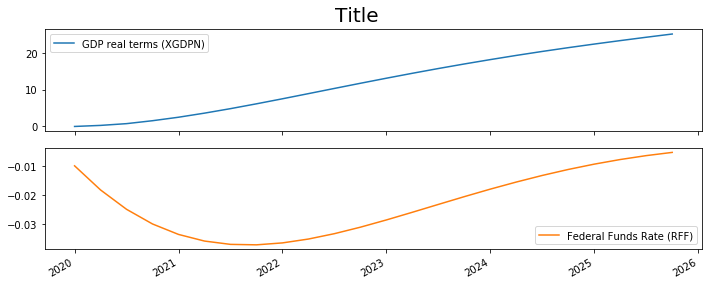

In [29]:
_ = mfrbus['XGDPN RFF'].dif.rename(trans).plot(colrow=1,sharey=0)

# Some interfaces 
. (dot) makes it easy to look at single variable. 

\[ \] (Slice) alows inspection of many variables selected with wildcars

In [30]:
 # we only want a few quarters 
_ = mfrbus.smpl('2020q1','2021q1')

# How is the interest rate determined

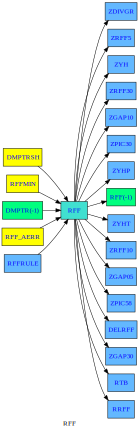

In [31]:
mfrbus.RFF.draw(up=1,down=1,HR=0,svg=1)

In [32]:
mfrbus.rff.show

Endogeneous: RFF 
Formular: FRML  <> RFF=(1-DMPTRSH)*(RECODE((RFFRULE)>(RFFMIN),RFFRULE,RFFMIN))+DMPTRSH*(RECODE(((DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN))>(RFFMIN),(DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN),RFFMIN))+RFF_AERR  $
Values : 
        2020Q1    2020Q2    2020Q3    2020Q4    2021Q1
Base  3.153624  3.250023  3.324873  3.378474  3.411382
Last  3.143625  3.231768  3.299996  3.348576  3.377909
Diff -0.009999 -0.018255 -0.024878 -0.029899 -0.033472

Input last run: 
                  2020Q1        2020Q2        2020Q3        2020Q4  \
DMPTR(-1)  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
DMPTRSH    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
RFFMIN     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
RFFRULE    3.143622e+00  3.231768e+00  3.299997e+00  3.348578e+00   
RFF_AERR  -6.833184e-17 -6.833184e-17 -6.833184e-17 -6.833184e-17   

                 2021Q1  
DMPTR(-1)  1.000000e+00  
DMPTRSH    0.000000e+00  
RFFMIN     0.000000e+00  
RFFRU

In [33]:
_= mfrbus.rffintay.dekomp(start='2020q1',end='2021q1')

Formula        : FRML  <> RFFINTAY=.85*RFF(-1)+(1-.85)*(RSTAR+(PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4+0.5*((PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4-PITARG)+1.0*XGAP2)+RFFINTAY_AERR  $ 

                    2020Q1     2020Q2     2020Q3     2020Q4     2021Q1
Variable    lag                                                       
Base        0     3.153624   3.250023   3.324873   3.378474   3.411382
Alternative 0     3.143622   3.231768   3.299997   3.348578   3.377909
Difference  0    -0.010002  -0.018255  -0.024877  -0.029897  -0.033472
Percent     0    -0.317149  -0.561694  -0.748203  -0.884922  -0.981199

 Contributions to differende for  RFFINTAY
                      2020Q1     2020Q2     2020Q3     2020Q4     2021Q1
Variable      lag                                                       
RFF           -1    0.000001  -0.008500  -0.015517  -0.021146  -0.025414
RSTAR          0    0.000001  -0.000000  -0.000000  -0.000000  -0.000000
PICXFE         0    0.000001   0.000005   0.0

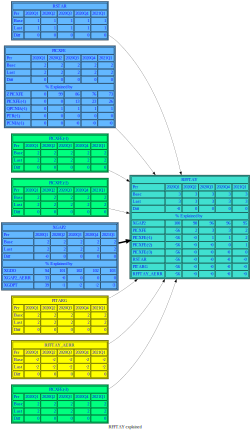

In [34]:
_ = mfrbus.rfftay.explain(up=1,svg=1,pdf=0)

In [35]:
mfrbus['rffta* rffrule*']

          RFFTAY  RFFTAY_AERR   RFFRULE  RFFRULE_AERR
2020Q1  3.096484    -1.960046  3.143622  2.400000e-10
2020Q2  3.087531    -1.960046  3.231768  3.550000e-09
2020Q3  3.060563    -1.960046  3.299997 -5.000007e-11
2020Q4  3.016362    -1.960046  3.348578 -1.900001e-10
2021Q1  2.962290    -1.960046  3.377909 -5.300001e-10

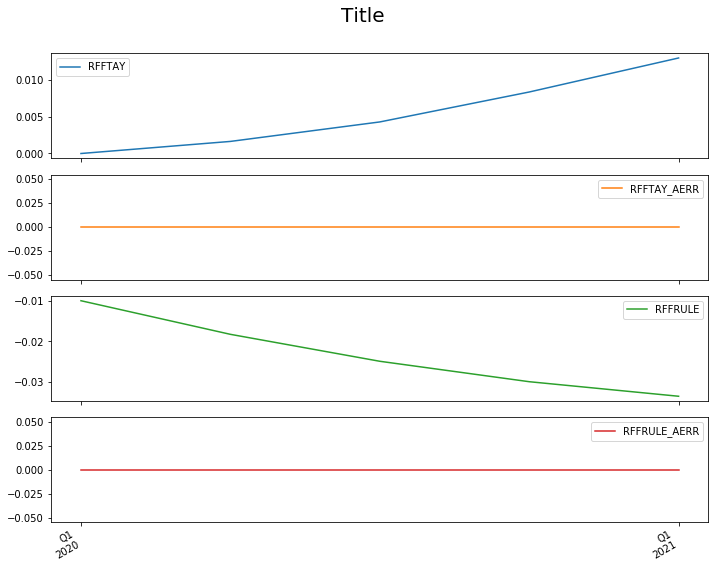

In [36]:
_ = mfrbus['rffta* rffrule*'].dif.plot(colrow=1,sharey=0)

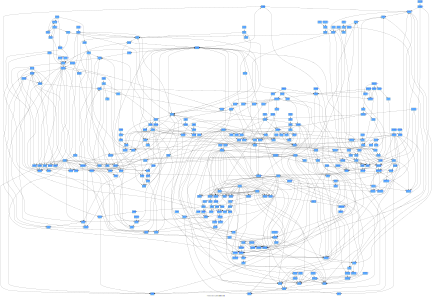

In [37]:
mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',svg=1)
# you will find the output files in different format in the /graph folder

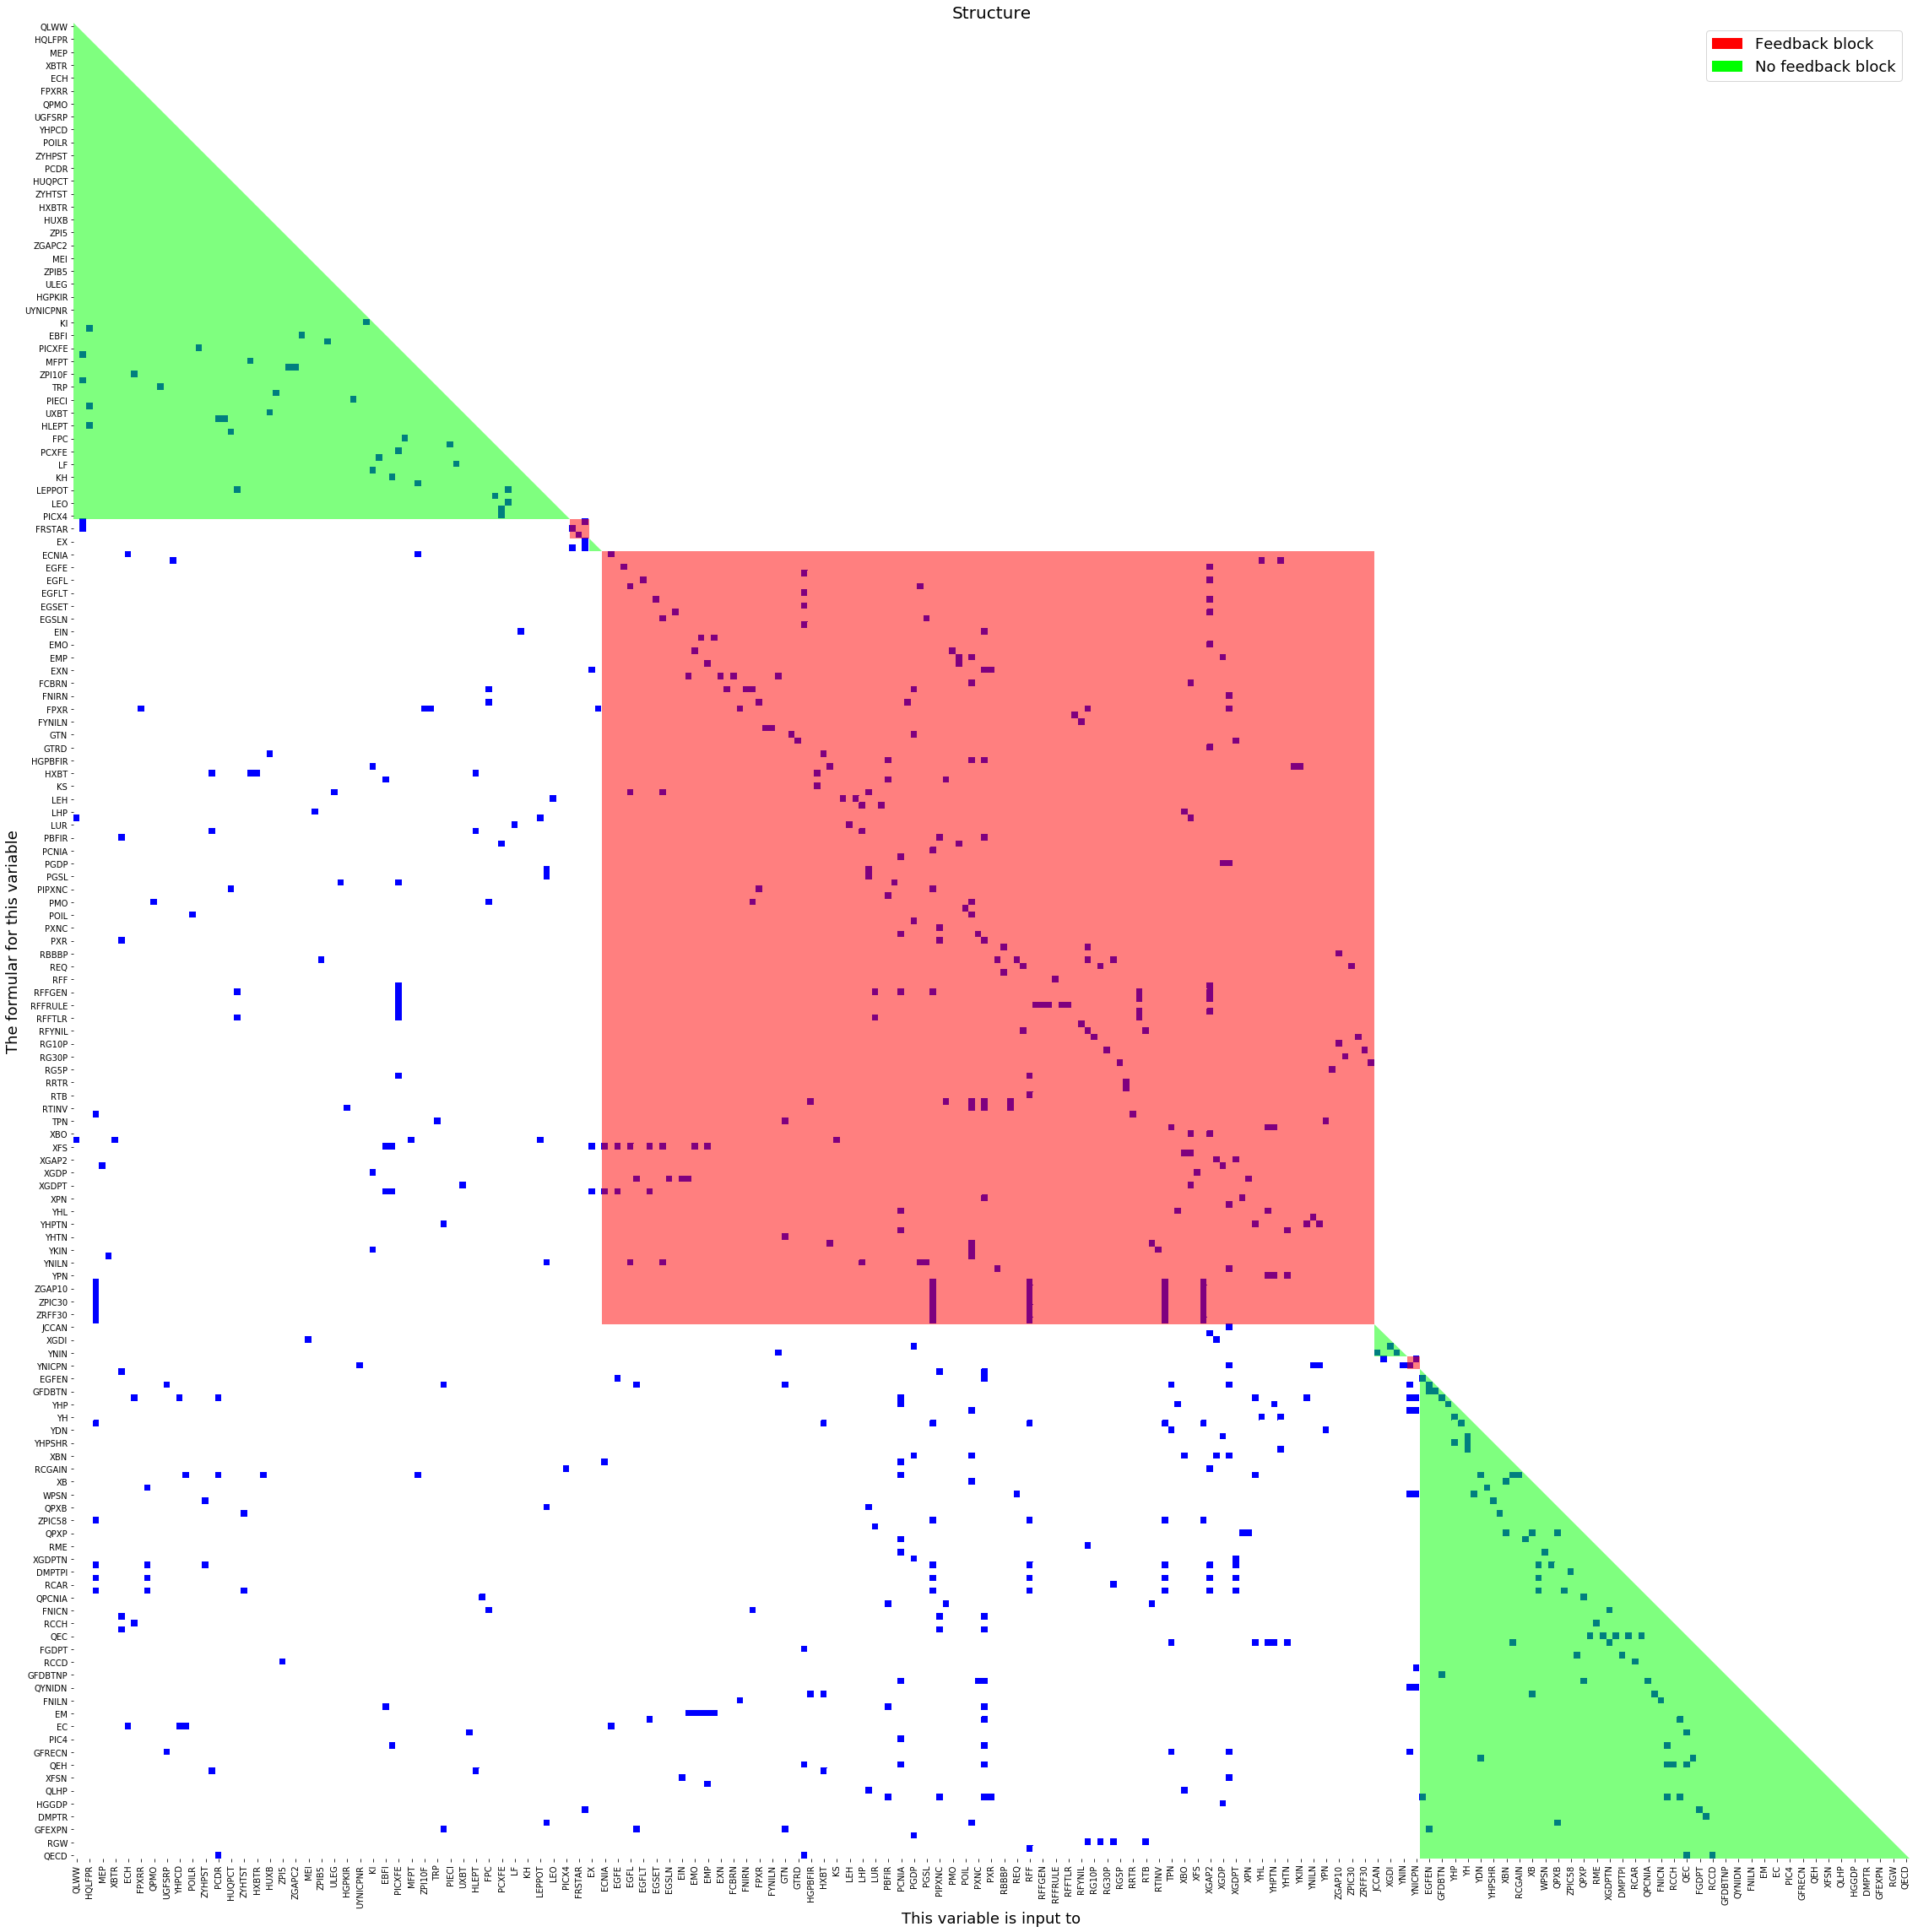

In [38]:
fig   = draw_adjacency_matrix(mfrbus.endograph,mfrbus.precoreepiorder,
                                          mfrbus._superstrongblock,mfrbus._superstrongtype,size=(40,40))
#fig.savefig('graph/FRB-US causality structure.pdf')